# IFRS9 portfolio analytics

## Setup

### Imports

In [1]:
import atoti as tt
from atoti._providers import bitmap, leaf

Welcome to atoti 0.5.0!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


### Session

In [2]:
session = tt.create_session(
    name='Main session',
    config='./configuration.yaml'
)

## Data Store

### Stores

In [3]:
# !conda install atoti-aws -y

In [4]:
src = "/Users/anastasiapolyakova/dev/activeviam/demo/python-ifrs9-demo-v0/data/"
# src = "s3://data.atoti.io/notebooks/ifrs9/"

In [5]:
contracts_store = session.read_csv(
    src + 'formatted/contracts/',
    keys=['Reporting Date', 'Contract ID', 'Legal Entity'],
    store_name='Contracts',
    types={
        'EAD': tt.type.NULLABLE_DOUBLE,
        'On Balance EAD': tt.type.NULLABLE_DOUBLE,
        'Off Balance EAD': tt.type.NULLABLE_DOUBLE
    },
    partitioning='hash4(Reporting Date)|hash8(Contract ID)|hash2(Legal Entity)'
)

previous_contracts_store = session.read_csv(
    src + 'formatted/contracts_previous/',
    keys=['Reporting Date', 'Contract ID', 'Legal Entity'],
    store_name='Previous Contracts',
    partitioning='hash4(Reporting Date)|hash8(Contract ID)|hash2(Legal Entity)'
)

clients_store = session.read_csv(
    src + 'formatted/clients/',
    keys=['Reporting Date', 'Client ID', 'Legal Entity'],
    store_name='Clients',
    partitioning='hash4(Reporting Date)|hash2(Legal Entity)'
)

previous_clients_store = session.read_csv(
    src + 'formatted/clients_previous/',
    keys=['Reporting Date', 'Client ID', 'Legal Entity'],
    store_name='Previous Clients',
    partitioning='hash4(Reporting Date)|hash2(Legal Entity)'
)

contracts_static_store = session.read_csv(
    src + 'formatted/static/contracts.csv',
    keys=['Contract ID', 'Legal Entity'],
    store_name='Contracts (static)',
    partitioning='hash8(Contract ID)|hash2(Legal Entity)'
)

credit_cards_store = session.read_csv(
    src + 'formatted/credit_cards/',
    keys=['Client ID',  'Reporting Date'],
    store_name='Credit Cards',
    types={
        'Credit Limit': tt.type.LONG,
        'DaysCardDefault': tt.type.NULLABLE_DOUBLE
    },
    partitioning='hash4(Reporting Date)'
)

previous_credit_cards_store = session.read_csv(
    src + 'formatted/credit_cards_previous/',
    keys=['Client ID',  'Reporting Date'],
    store_name='Previous Credit Cards',
    partitioning='hash4(Reporting Date)'
)

The store has been sampled because there are more than 5 lines in the files to load. Call Session.load_all_data() to trigger the full load of the data.


### References

In [6]:
credit_cards_store.join(previous_credit_cards_store)
clients_store.join(credit_cards_store)
clients_store.join(previous_clients_store)
contracts_store.join(clients_store)
contracts_store.join(previous_contracts_store)
contracts_store.join(contracts_static_store)

## Cube

In [7]:
cube = session.create_cube(contracts_store, 'IFRS9', mode='no_measures')
cube.aggregates_cache.capacity = 1000

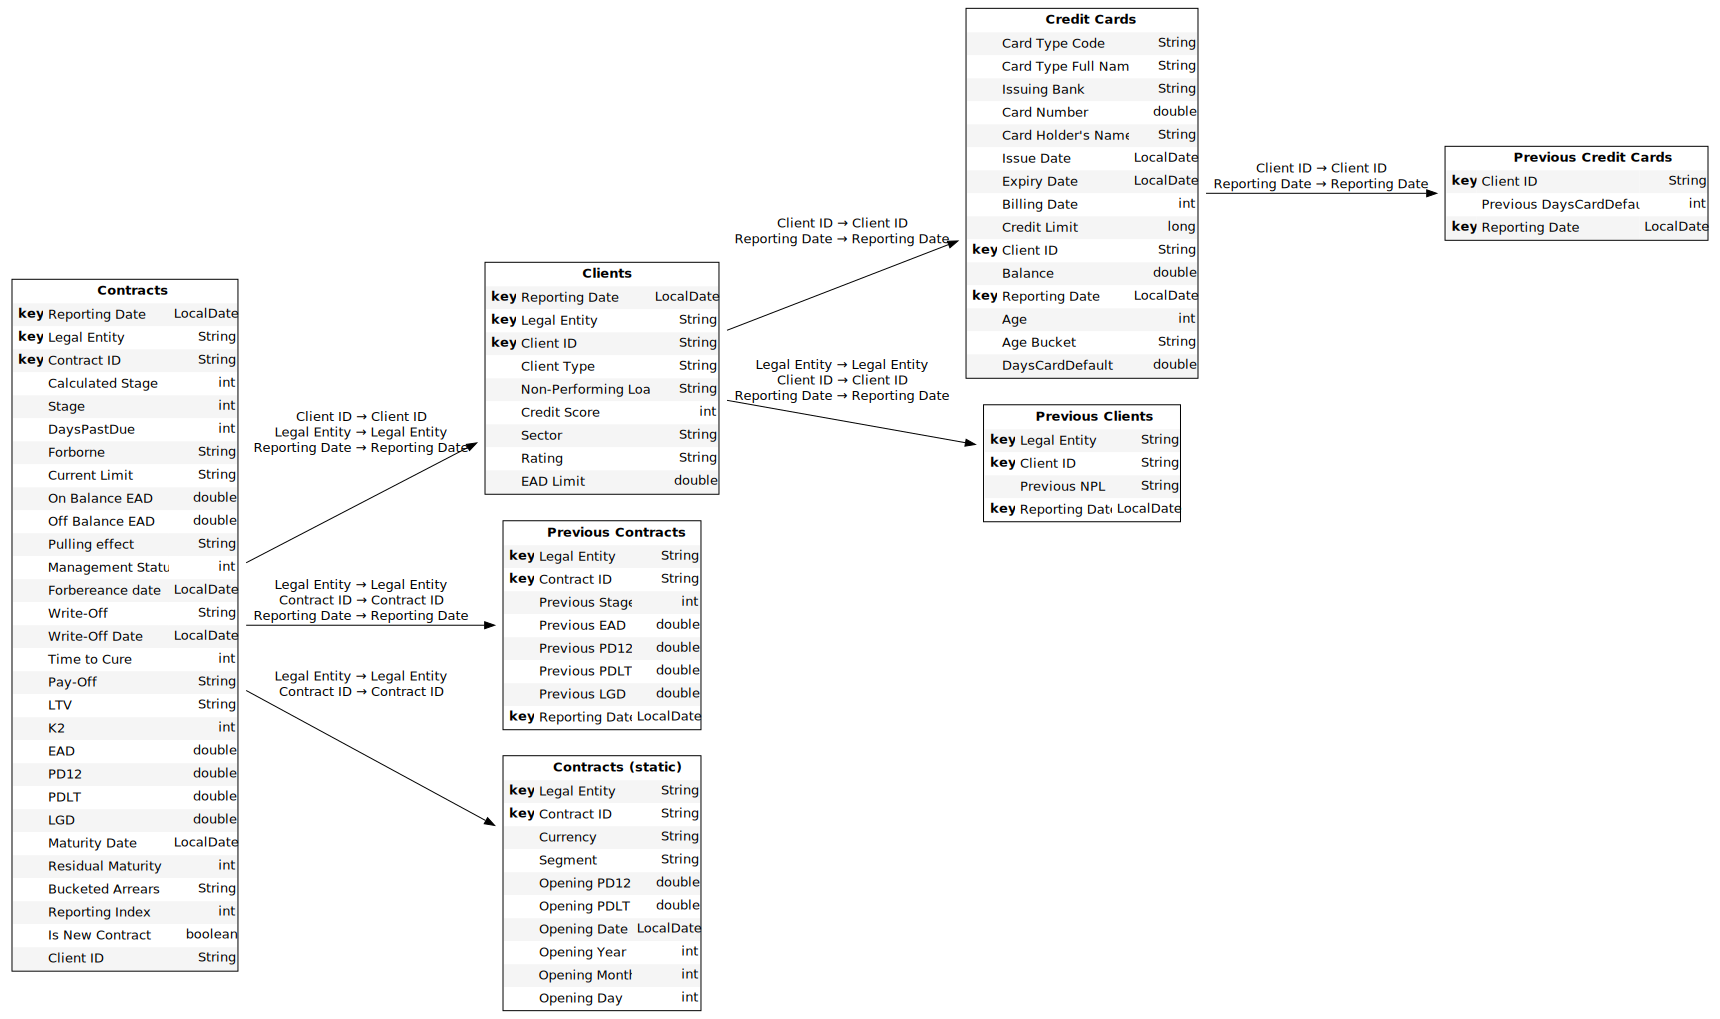

In [8]:
cube.schema

### Hierarchies

In [9]:
h = cube.hierarchies
l = cube.levels

#### Removed hierarchies

In [10]:
del h['Segment']
del h['Opening Year']
del h['Opening Month']
del h['Opening Day']
del h['K2']
del h['LTV']
del h['DaysPastDue']
del h['Residual Maturity']
del h['Credit Limit']

#### Slicing hierarchies

In [11]:
h['Legal Entity'].slicing = True

#### Multi-level hierarchies

In [12]:
h['Opening Date (detailed)'] = {
    'Year': contracts_static_store['Opening Year'],
    'Month': contracts_static_store['Opening Month'],
    'Day': contracts_static_store['Opening Day']
}

h['Segments'] = {
    'Segment': contracts_static_store['Segment'],
    'Contract': contracts_store['Contract ID']
}

### Measures

In [13]:
m = cube.measures

Define formatting

In [14]:
percent_formatter = 'DOUBLE[#,###.##%]'

#### Dates

The **Residual Maturity** is the number of days from the **Reporting Date** to the **Maturity Date**.

In [15]:
m['Residual Maturity'] = tt.agg.mean(contracts_store['Residual Maturity'])
m['Residual Maturity'].folder = 'Date'

In [16]:
cube.query(m['Residual Maturity'])

,Residual Maturity
0,"1,434.00"


#### Stages

**Impairment** of financial assets is recognised in stages:
- **Stage 1** As soon as a financial instrument is originated or purchased, 12-month expected credit losses are recognised in profit or loss and a loss allowance is established. This serves as a proxy for the initial expectations of credit losses. For financial assets, interest revenue is calculated on the gross carrying amount (ie without deduction for expected credit losses).
- **Stage 2** If the credit risk increases significantly and is not considered low, full lifetime expected credit losses are recognised in profit or loss. The calculation of interest revenue is the same as for Stage 1.
- **Stage 3** If the credit risk of a financial asset increases to the point that it is considered credit-impaired, interest revenue is calculated based on the amortised cost (ie the gross carrying amount less the loss allowance). Financial assets in this stage will generally be assessed individually. Lifetime expected credit losses are recognised on these financial assets.

Input

In [17]:
m['Stage'] = tt.value(contracts_store['Stage'])
m['Stage'].folder = 'Stage'

Day to day

In [18]:
m['Previous Stage'] = tt.shift(m['Stage'], on=l['Reporting Date'], offset=-1)
m['Previous Stage'].folder = 'Stage'

m['Stage Variation'] = tt.where(m['Stage'] != m['Previous Stage'], 1, -1)
m['Stage Variation'].folder = 'Stage'

In [19]:
cube.query(m['Stage'], m['Previous Stage'])

,Stage,Previous Stage


#### EAD

The **Exposure At Default** is the predicted amount of loss a bank may be exposed to when a debtor defaults on a loan.

Input

In [20]:
m['On Balance EAD'] = tt.agg.sum(contracts_store['On Balance EAD'])
m['On Balance EAD'].folder = 'EAD'

m['Off Balance EAD'] = tt.agg.sum(contracts_store['Off Balance EAD'])
m['Off Balance EAD'].folder = 'EAD'

m['EAD'] = tt.agg.sum(contracts_store['EAD'])
m['EAD'].folder = 'EAD'

In [21]:
cube.query(m['On Balance EAD'], m['Off Balance EAD'], m['EAD'])

,On Balance EAD,Off Balance EAD,EAD
0,<NA>,<NA>,"26,466.00"


Day to day

In [22]:
m['Previous EAD'] = tt.shift(m['EAD'], on=l['Reporting Date'], offset=-1)
m['Previous EAD'].folder = 'EAD'

m['EAD (DtD)'] = tt.where(m['Previous EAD'] != None, m['EAD'] - m['Previous EAD'])
m['EAD (DtD)'].folder = 'EAD'

m['EAD (DtD %)'] = tt.where(m['Previous EAD'] != 0, m['EAD (DtD)'] / m['Previous EAD'])
m['EAD (DtD %)'].folder = 'EAD'
m['EAD (DtD %)'].formatter = percent_formatter

In [23]:
cube.query(m['EAD'], m['Previous EAD'], m['EAD (DtD)'], m['EAD (DtD %)'], condition = (l['Reporting Date']=="2019-06-30"))

,EAD,Previous EAD,EAD (DtD),EAD (DtD %)


#### PD

The **Probability Of Default** is the likelihood that your debtor will default on its debts (goes bankrupt or so) within certain period (12 months for loans in Stage 1 and life-time for other loans).

##### 12 months

Input

In [24]:
m['PD (12)'] = tt.agg.mean(contracts_store['PD12'])
m['PD (12)'].folder = 'PD'
m['PD (12)'].formatter = percent_formatter

m['Opening PD (12)'] = tt.agg.mean(contracts_static_store['Opening PD12'])
m['Opening PD (12)'].folder = 'PD'

Day to day

In [25]:
m['Previous PD (12)'] = tt.shift(m['PD (12)'], on=l['Reporting Date'], offset=-1)
m['Previous PD (12)'].folder = 'PD'
m['Previous PD (12)'].formatter = percent_formatter

m['PD (12) (DtD)'] = tt.where(m['Previous PD (12)'] != None, m['PD (12)'] - m['Previous PD (12)'])
m['PD (12) (DtD)'].folder = 'PD'

m['PD (12) (DtD %)'] = tt.where(m['Previous PD (12)'] != 0, m['PD (12) (DtD)'] / m['Previous PD (12)'])
m['PD (12) (DtD %)'].folder = 'PD'
m['PD (12) (DtD %)'].formatter = percent_formatter

Variation from opening

In [26]:
m['PD (12) Variation'] = (m['PD (12)'] - m['Opening PD (12)']) / m['Opening PD (12)']
m['PD (12) Variation'].folder = 'PD'
m['PD (12) Variation'].formatter = percent_formatter

##### Life time

Input

In [27]:
m['PD (LT)'] = tt.agg.mean(contracts_store['PDLT'])
m['PD (LT)'].folder = 'PD'
m['PD (LT)'].formatter = percent_formatter

m['Opening PD (LT)'] = tt.agg.mean(contracts_static_store['Opening PDLT'])
m['Opening PD (LT)'].folder = 'PD'

Day to day

In [28]:
m['Previous PD (LT)'] = tt.shift(m['PD (LT)'], on=l['Reporting Date'], offset=-1)
m['Previous PD (LT)'].folder = 'PD'

m['PD (LT) (DtD)'] = tt.where(m['Previous PD (LT)'] != None, m['PD (LT)'] - m['Previous PD (LT)'])
m['PD (LT) (DtD)'].folder = 'PD'

m['PD (LT) (DtD %)'] = tt.where(m['Previous PD (LT)'] != 0, m['PD (LT) (DtD)'] / m['Previous PD (LT)'])
m['PD (LT) (DtD %)'].folder = 'PD'
m['PD (LT) (DtD %)'].formatter = percent_formatter

Variation from opening

In [29]:
m['PD (LT) Variation'] = (m['PD (LT)'] - m['Opening PD (LT)']) / m['Opening PD (LT)']
m['PD (LT) Variation'].folder = 'PD'
m['PD (LT) Variation'].formatter = percent_formatter

#### LGD

The **Lost Given Default** is the percentage that you can lose when the debtor defaults.

In [30]:
m['LGD'] = tt.agg.sum(contracts_store['LGD'])
m['LGD'].folder = 'LGD'

m['Previous LGD'] = tt.shift(m['LGD'], on=l['Reporting Date'], offset=-1)
m['Previous LGD'].folder = 'LGD'

#### ECL

The **Expected Credit Loss** is a probability-weighted estimate of credit loss. A credit loss is the difference between the cash flows that are due to an entity in accordance with the contract and the cash flows that the entity expects to receive discounted at the original effective interest rate. Because ECL consider the amount and timing of payments, a credit loss arises even if the entity expects to be paid in full but later than when contractually due

##### ECL calculations

Input

In [31]:
ecl_stage_1 = tt.agg.sum_product(contracts_store['LGD'], contracts_store['EAD'], contracts_store['PD12'])
ecl_stage_2 = tt.agg.sum_product(contracts_store['LGD'], contracts_store['EAD'], contracts_store['PDLT'])
ecl_stage_3 = tt.agg.sum_product(contracts_store['LGD'], contracts_store['EAD'])

m['ECL']  = tt.filter(ecl_stage_1, l['Stage'] == 1) + tt.filter(ecl_stage_2, l['Stage'] == 2) + tt.filter(ecl_stage_3, l['Stage'] == 3)
m['ECL'].folder = 'ECL'

Day to day

In [32]:
m['Previous ECL'] = tt.shift(m['ECL'], on=l['Reporting Date'], offset=-1)
m['Previous ECL'].folder = 'ECL'

m['ECL (DtD)'] = tt.where(m['Previous ECL'] != None, m['ECL'] - m['Previous ECL'])
m['ECL (DtD)'].folder = 'ECL'

m['ECL (DtD %)'] = tt.where(m['Previous ECL'] != 0, m['ECL (DtD)'] / m['Previous ECL'])
m['ECL (DtD %)'].folder = 'ECL'
m['ECL (DtD %)'].formatter = percent_formatter

m['ECL of old contracts'] = tt.filter(m['ECL'], l['Is New Contract'] == False)
m['ECL of old contracts'].folder = 'ECL'

m['ECL (DtD without new contracts)'] = tt.where(m['Previous ECL'] != None, m['ECL of old contracts'] - m['Previous ECL'])
m['ECL (DtD without new contracts)'].folder = 'ECL'

m['ECL (DtD % without new contracts)'] = tt.where(m['Previous ECL'] != 0, m['ECL (DtD without new contracts)'] / m['Previous ECL'])
m['ECL (DtD % without new contracts)'].folder = 'ECL'
m['ECL (DtD % without new contracts)'].formatter = percent_formatter

In [33]:
cube.query(m['Previous ECL'], m['ECL'], levels = l['Reporting Date'])

,Previous ECL,ECL
Reporting Date,,
2018-07-31,<NA>,"4,928.54"


##### ECL Explainer

The **ECL Explainer** is measured via the variation due to PD or LGD or EAD changes. Using the same formula as for the ECL measure, one of these 3 values (PD, LGD or EAD) is replaced by the value on the previous reporting date so it has no effect on the ECL variation.

ECL variation due to PD changes

In [34]:
ecl_pd_explain_stage_1 = tt.agg.sum_product(contracts_store['LGD'], contracts_store['EAD'], previous_contracts_store['Previous PD12'])
ecl_pd_explain_stage_2 = tt.agg.sum_product(contracts_store['LGD'], contracts_store['EAD'], previous_contracts_store['Previous PDLT'])

ecl_with_previous_pd = tt.filter(ecl_pd_explain_stage_1, l['Stage'] == 1) + tt.filter(ecl_pd_explain_stage_2, l['Stage'] == 2) + tt.filter(ecl_stage_3, l['Stage'] == 3)

m['ECL variation due to PD changes'] = m['ECL'] - ecl_with_previous_pd
m['ECL variation due to PD changes'].folder = 'ECL'
m['ECL variation due to PD changes (%)'] = m['ECL variation due to PD changes'] / m['ECL (DtD)']
m['ECL variation due to PD changes (%)'].folder = 'ECL'
m['ECL variation due to PD changes (%)'].formatter = percent_formatter

ECL variation due to LGD changes

In [35]:
ecl_lgd_explain_stage_1 = tt.agg.sum_product(previous_contracts_store['Previous LGD'], contracts_store['EAD'], contracts_store['PD12'])
ecl_lgd_explain_stage_2 = tt.agg.sum_product(previous_contracts_store['Previous LGD'], contracts_store['EAD'], contracts_store['PDLT'])
ecl_lgd_explain_stage_3 = tt.agg.sum_product(previous_contracts_store['Previous LGD'], contracts_store['EAD'])

ecl_with_previous_lgd = tt.filter(ecl_lgd_explain_stage_1, l['Stage'] == 1) + tt.filter(ecl_lgd_explain_stage_2, l['Stage'] == 2) + tt.filter(ecl_lgd_explain_stage_3, l['Stage'] == 3)

m['ECL variation due to LGD changes'] = m['ECL'] - ecl_with_previous_lgd
m['ECL variation due to LGD changes'].folder = 'ECL'
m['ECL variation due to LGD changes (%)'] = m['ECL variation due to LGD changes'] / m['ECL (DtD)']
m['ECL variation due to LGD changes (%)'].folder = 'ECL'
m['ECL variation due to LGD changes (%)'].formatter = percent_formatter

ECL variation due to EAD changes

In [36]:
ecl_ead_explain_stage_1 = tt.agg.sum_product(contracts_store['LGD'], previous_contracts_store['Previous EAD'], contracts_store['PD12'])
ecl_ead_explain_stage_2 = tt.agg.sum_product(contracts_store['LGD'], previous_contracts_store['Previous EAD'], contracts_store['PDLT'])
ecl_ead_explain_stage_3 = tt.agg.sum_product(contracts_store['LGD'], previous_contracts_store['Previous EAD'])

ecl_with_previous_ead = tt.filter(ecl_ead_explain_stage_1, l['Stage'] == 1) + tt.filter(ecl_ead_explain_stage_2, l['Stage'] == 2) + tt.filter(ecl_ead_explain_stage_3, l['Stage'] == 3)

m['ECL variation due to EAD changes'] = m['ECL'] - ecl_with_previous_ead
m['ECL variation due to EAD changes'].folder = 'ECL'
m['ECL variation due to EAD changes (%)'] = m['ECL variation due to EAD changes'] / m['ECL (DtD)']
m['ECL variation due to EAD changes (%)'].folder = 'ECL'
m['ECL variation due to EAD changes (%)'].formatter = percent_formatter

#### Curring Time

The **curing time** is ponderated per contract by the EAD. The way to ponderate is to multiply the curing time of each contract by its EAD and then divide by the total EAD of the segment associated with the contract.

In [37]:
m['Time to Cure'] = tt.value(contracts_store['Time to Cure'])
m['Time to Cure'].folder = 'Curring Time'

m['Average Time to Cure'] = tt.agg.mean(contracts_store['Time to Cure'])
m['Average Time to Cure'].folder = 'Curring Time'

total_segment_ead = tt.parent_value(m['EAD'],{h['Segments']:1})

m['Curring Time (EAD weighted)'] = tt.agg.sum(
    tt.where(total_segment_ead != 0, m['Time to Cure'] * m['EAD'] / total_segment_ead),
    scope=tt.scope.origin(l['Contract ID'])
)
m['Curring Time (EAD weighted)'].folder = 'Curring Time'

m['Average Curring Time (EAD weighted)'] = tt.agg.mean(m['Curring Time (EAD weighted)'], scope=tt.scope.origin(l['Contract ID']))
m['Average Curring Time (EAD weighted)'].folder = 'Curring Time'

In [38]:
cube.query(m['Curring Time (EAD weighted)'])

,Curring Time (EAD weighted)


#### NPL

A bank loan is considered non-performing when more than 90 days pass without the borrower paying the agreed instalments or interest. **Non-performing loans** are also called "bad debt".

Input

In [39]:
m['NPL'] = tt.value(clients_store['Non-Performing Loan'])
m['NPL'].folder = 'NPL'

Day to day

In [40]:
m['Previous NPL'] = tt.shift(m['NPL'], on=l['Reporting Date'], offset=-1)
m['Previous NPL'].folder = 'NPL'

m['NPL Variation'] = tt.where(m['NPL'] != m['Previous NPL'], 1, -1)
m['NPL Variation'].folder = 'NPL'

#### Matrix

In credit risk, the term 'Vintage' refers to the month or quarter in which account was opened (loan was granted). In simple words, the vintage analysis measures the performance of a portfolio in different periods of time after the loan (or credit card) was granted. Performance can be measured in the form of cumulative charge-off rate, proportion of customers 30/60/90 days past due (DPD), utilization ratio, average balance etc.

Days Past Due

In [41]:
m['DaysPastDue'] = tt.agg.mean(contracts_store['DaysPastDue'])
m['DaysPastDue'].folder = 'Matrix'

m['Minimum DaysPastDue'] = tt.agg.min(contracts_store['DaysPastDue'])
m['Minimum DaysPastDue'].folder = 'Matrix'

m['Maximum DaysPastDue'] = tt.agg.max(contracts_store['DaysPastDue'])
m['Maximum DaysPastDue'].folder = 'Matrix'

% of Contracts

In [42]:
index_zero_count = tt.at(m['contributors.COUNT'], {l['Reporting Index']: 0})
index_zero_count_foreach_index = tt.filter(index_zero_count, l['Reporting Index'] > 1)
count_of_dayspastdue = tt.agg.sum(tt.where(m['DaysPastDue'] > 1, m['contributors.COUNT']), scope=tt.scope.origin(l['Contract ID']))

m['% of Contracts'] = tt.agg.mean(count_of_dayspastdue / index_zero_count_foreach_index, scope=tt.scope.origin(l['Month']))
m['% of Contracts'].formatter = percent_formatter
m['% of Contracts'].folder = 'Matrix'

In [43]:
cube.query(m['ECL'], m['Previous ECL'])

,ECL,Previous ECL
0,"4,928.54",<NA>


#### Credit Cards

Input

In [44]:
m['Contracts Number'] = tt.agg.count_distinct(contracts_store['Contract ID'])
m['Contracts Number'].folder = 'Cards'
m['Segments Number'] = tt.agg.count_distinct(contracts_static_store['Segment'])
m['Segments Number'].folder = 'Cards'

days_card_default_init_bitmap = tt.agg.sum(credit_cards_store['DaysCardDefault']) 

Default

In [45]:
days_card_default_init = tt.filter(days_card_default_init_bitmap, l['Client Type'] == 'Individual')

m['DaysCardDefault'] = tt.agg._stop(tt.agg.sum(days_card_default_init / m['Contracts Number'], scope=tt.scope.origin(l['Client ID'])),l['Card Holder\'s Name'])
m['DaysCardDefault'].folder = 'Cards'

m['Total number default dates'] = tt.agg.sum(
    tt.agg.sum(
        tt.where(days_card_default_init != 0, 1),
        scope = tt.scope.cumulative(l['Reporting Date'])
    ),
    scope=tt.scope.origin(l['Client ID'])
)
m['Total number default dates'].folder = 'Cards'

m['New Default'] = tt.agg.sum(
    tt.where(
        (days_card_default_init != 0) & (tt.agg.sum(previous_credit_cards_store['Previous DaysCardDefault']) == 0),
        1
    ),
    scope=tt.scope.origin(l['Client ID'], l['Reporting Date'])
)
m['New Default'].folder = 'Cards'

## Data loading

In [46]:
# session.load_all_data()

### Simulations

#### Measure simulations
In order to create a simulation, you need to answer to the following points:
- How to define the scope of the simulation.
- On what measure is the simulation about.
- What kind of simulation is it.

In this example:
- The scope is defined by the Reporting Date, the Legal Entity, the Rating and the Client Type levels.
- The simulation will be done on the EAD measure.
- The EAD is going to be scaled.

There are 2 ways to perform simulations with this schema:
- From ActiveUI (menu Measure simulations).
- From the Notebook, with the command below as example.

#### Enable source simulations

In [47]:
contracts_store.source_simulation_enabled = True
clients_store.source_simulation_enabled = True
contracts_static_store.source_simulation_enabled = True

## Limits

#### EAD

In [48]:
m['EAD Limit'] = tt.agg.mean(clients_store['EAD Limit'])
m['EAD Limit'].folder = 'Limits'

m['EAD Utilisation %'] = tt.where(m['EAD Limit'] != 0.0, tt.agg.mean(m['EAD']/ m['EAD Limit'], scope=tt.scope.origin(l['Client ID'])))
m['EAD Utilisation %'].formatter = percent_formatter
m['EAD Utilisation %'].folder = 'Limits'

m['EAD Utilisation Absolute'] = m['EAD Limit'] - m['EAD']
m['EAD Utilisation Absolute'].folder = 'Limits'

#### Credit Cards

In [49]:
credit_card_limit_initial = tt.agg.sum(credit_cards_store['Credit Limit'])
m['Credit Card Limit'] = tt.filter(credit_card_limit_initial, l['Segment'] == 'Cards')
m['Credit Card Limit'].folder = 'Cards'

balance_initial = tt.agg.sum(credit_cards_store['Balance'])
m['Balance'] = tt.filter(balance_initial, l['Segment'] == 'Cards')
m['Balance'].folder = 'Cards'

m['Card Utilisation %'] = m['Balance'] / m['Credit Card Limit']
m['Card Utilisation %'].formatter= percent_formatter
m['Card Utilisation %'].folder = 'Cards'

m['Card Utilisation Absolute'] = m['Credit Card Limit'] - m['Balance']
m['Card Utilisation Absolute'].folder = 'Cards'

In [50]:
session.url

'http://localhost:40751'

## Bitmap

**Warning**: a measure used for measure simulation can not be included into the Bitmap.

In [51]:
cube._aggregate_providers = [
    leaf(
        levels=[
            l['Client ID'],
            l['Reporting Date'],
            l['Legal Entity'],
            l['Segment'],
            l['Client Type'],
            l['Stage']
        ], 
        measures=[
            m['EAD Limit'], 
            m['EAD'], 
            m['LGD'], 
#             m['NPL'],
#             m['Stage'],
            m['Residual Maturity'],
            m['Off Balance EAD'],
            m['On Balance EAD'],
            m['PD (12)'],
            m['Opening PD (12)'],
            m['LGD'],
#             m['Time to Cure'],
            m['DaysPastDue'],
            m['Minimum DaysPastDue'],
            m['Maximum DaysPastDue'],
            credit_card_limit_initial,
            balance_initial,
            m['Contracts Number'],
            days_card_default_init_bitmap,
            ecl_stage_1,
            ecl_stage_2,
            ecl_stage_3,
            ecl_pd_explain_stage_1,
            ecl_pd_explain_stage_2,
            ecl_lgd_explain_stage_1,
            ecl_lgd_explain_stage_2,
            ecl_lgd_explain_stage_3,
            ecl_ead_explain_stage_1,
            ecl_ead_explain_stage_2,
            ecl_ead_explain_stage_3
        ]
    )
]